<a href="https://colab.research.google.com/github/tonyankit/tonyankit/blob/main/Age_and_Gender_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'utkface-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44109%2F78156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240303%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240303T192147Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db1683e743f1a3a54e32b1c39f3a53e3883d7d65141d411449b3b51dcbaf6ccbc0b795d3b13c86a3040edc0cd5989bd7606727488eb5c95a5f1b06eb9271a3e81b1335668bff322122b1b4bca68c595d690687e81d5aa21135db0b4034ab1cadda58399b6b97e9c4440e21dd3ec170a2bbead249743488205573abcf91915ae68c12088879c94af861c72ab1faa5b7bc7632d8e13e995c65239b7e3e45afdcdd97c4aab80e2b2459a018f760ab7b99efa3a67daff66917a644fc455ad467f072b0f8c7b0aee4c325ba52faf3ad4de227f7c36b3b9a3eab8199cdb4f20c3aed6522b58fe47e69a44266d62d9bb5ed7a4de39c18970e489634e2ea4bc9343b0e6ac'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347342542 bytes downloaded
Downloaded and uncompressed: utkface-new
Data source import complete.


**Project Title: Gender and Age Prediction from Facial Images using Convolutional Neural Networks**

**Overview:**
In this project, I developed separate convolutional neural network (CNN) models to predict the gender and age of individuals from facial images. My goal was to accurately classify gender (male or female) and estimate age based on facial features extracted from images.

**Approach:**
1. **Data Collection:** I obtained a dataset containing facial images along with corresponding gender and age labels.
2. **Data Preprocessing:** The images were resized to a standard size (128x128 pixels) and converted to grayscale to reduce computational complexity. I also normalized the pixel values to improve model training.
3. **Model Architecture:** I designed two CNN models - one for gender prediction and one for age prediction. Both models consisted of convolutional layers followed by max-pooling layers, flattening, and dense layers. Dropout regularization was applied to prevent overfitting.
4. **Model Training:** The gender model was trained using binary cross-entropy loss and the age model was trained using mean absolute error loss. I utilized the Adam optimizer for training and evaluated model performance using accuracy metrics.
5. **Model Evaluation:** After training, I tested the performance of each model using a separate test dataset. I calculated the loss and accuracy of both models to assess their predictive capabilities.

**Results:**
1. **Gender Prediction:** The gender model achieved a certain level of accuracy in predicting the gender of individuals from facial images.
2. **Age Estimation:** The age model provided estimates of the age of individuals based on facial features extracted from images.
3. **Model Performance:** Both models were evaluated on the test dataset, and their respective loss and accuracy metrics were recorded to measure their performance.

**Conclusion:**
My project demonstrated the feasibility of predicting gender and estimating age from facial images using CNN models. While the models showed promising results, further optimization and fine-tuning could potentially improve their accuracy and generalization to unseen data. This project lays the foundation for future research in facial image analysis and applications in various domains such as biometrics, social demographics, and human-computer interaction.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity

In [3]:
path = Path("/kaggle/input/utkface-new/UTKFace")
filenames = [file.name for file in path.glob('*.jpg')]

In [4]:
print(len(filenames))
print(filenames[:3])

23708
['36_1_2_20170115234956957.jpg.chip.jpg', '26_0_1_20170116024232879.jpg.chip.jpg', '24_1_0_20170117145637012.jpg.chip.jpg']


In [5]:
# Shuffle the filenames
np.random.seed(10)
np.random.shuffle(filenames)

# Extract age and gender labels from filenames
image_paths = [str(file) for file in filenames]  # Convert Path objects to strings
age_labels = [file.split('_')[0] for file in filenames]
gender_labels = [file.split('_')[1] for file in filenames]

In [6]:
image_paths[:3]

['7_0_0_20161219201514284.jpg.chip.jpg',
 '29_1_3_20170104232640192.jpg.chip.jpg',
 '18_1_0_20170109214251980.jpg.chip.jpg']

In [7]:
df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels,
    'gender': gender_labels
})

In [8]:
df.head()

,image,age,gender
0,7_0_0_20161219201514284.jpg.chip.jpg,7,0
1,29_1_3_20170104232640192.jpg.chip.jpg,29,1
2,18_1_0_20170109214251980.jpg.chip.jpg,18,1
3,46_0_2_20170116192700927.jpg.chip.jpg,46,0
4,85_1_0_20170110183611657.jpg.chip.jpg,85,1


In [9]:
df.dtypes

image     object
age       object
gender    object
dtype: object

In [10]:
df = df.astype({'age':'float32', 'gender': 'int32'})

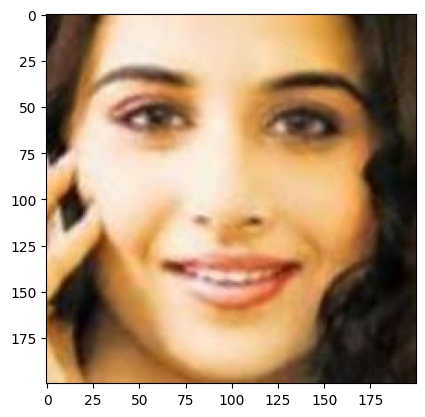

In [11]:
img = Image.open("/kaggle/input/utkface-new/UTKFace/" + df['image'][1])
plt.imshow(img)
plt.show()

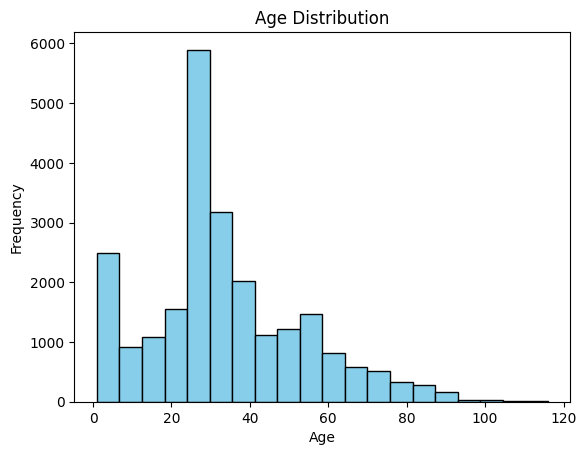

In [12]:
# Histogram of age
plt.hist(df['age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

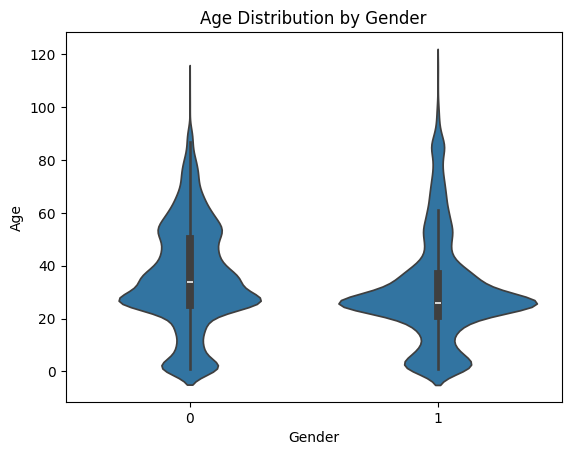

In [13]:
# Violin plot of age by gender
sns.violinplot(data=df, x='gender', y='age')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Age Distribution by Gender')
plt.show()

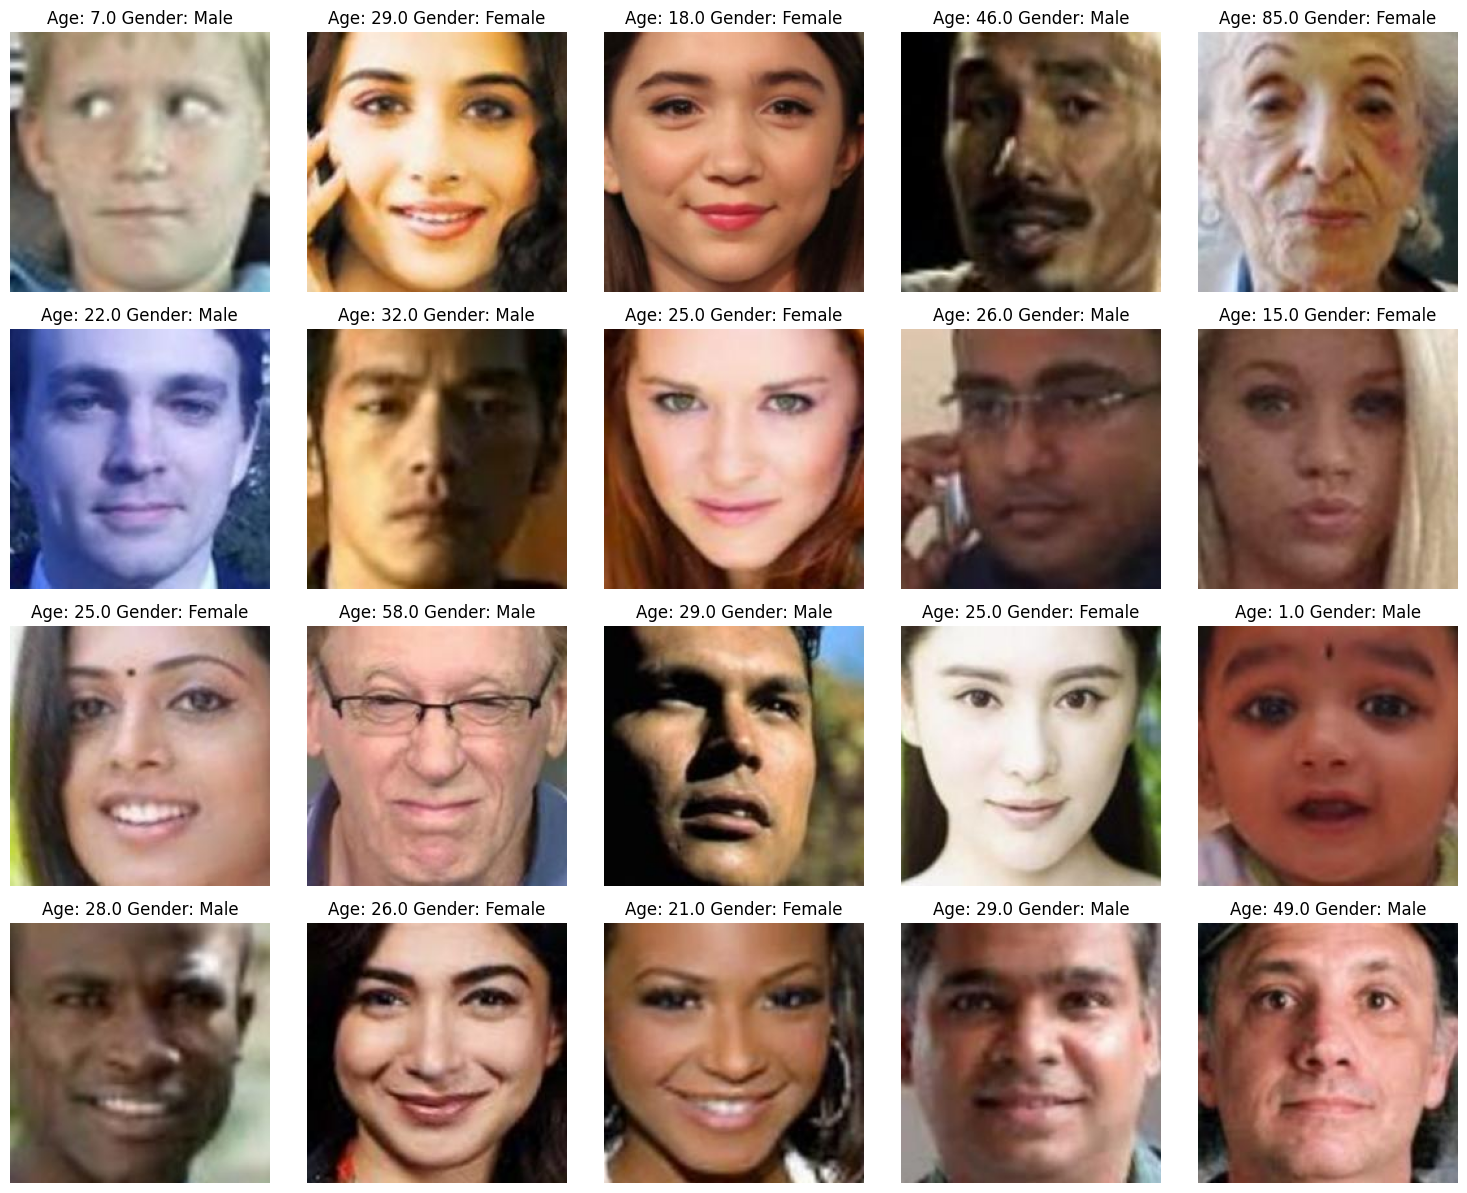

In [14]:
from keras.preprocessing.image import load_img

gender_dict = {0: 'Male', 1: 'Female'}

files = df.iloc[0:20]
plt.figure(figsize=(15, 15))
for index, (file, age, gender) in files.iterrows():
    plt.subplot(5, 5, index + 1)
    img = load_img("/kaggle/input/utkface-new/UTKFace/" + file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.85, random_state=42)

train.head()

,image,age,gender
18199,5_0_3_20170119212110570.jpg.chip.jpg,5.0,0
19557,89_1_0_20170110182442099.jpg.chip.jpg,89.0,1
20132,27_1_3_20170119194425619.jpg.chip.jpg,27.0,1
11849,28_1_2_20170116165530274.jpg.chip.jpg,28.0,1
2100,30_0_0_20170119145357069.jpg.chip.jpg,30.0,0


In [16]:
from keras.preprocessing.image import load_img

x_train = []
for file in train.image:
    img = load_img("/kaggle/input/utkface-new/UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
<ipython-input-16-82d3977cefa1>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128,128), Image.ANTIALIAS)


In [17]:
x_train.shape

(3556, 128, 128, 1)

In [18]:
x_train = x_train/255

In [19]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [20]:
input_size = (128, 128, 1)

In [21]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Model

inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [22]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 126, 126, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 42, 42, 64)           0         ['batch_normalization[0][0

In [24]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20
320/320 [==============================] - 128s 397ms/step - loss: 16.7689 - gender_output_loss: 0.6820 - age_output_loss: 16.0869 - gender_output_accuracy: 0.6503 - age_output_accuracy: 0.0456 - val_loss: 24.0830 - val_gender_output_loss: 0.6408 - val_age_output_loss: 23.4422 - val_gender_output_accuracy: 0.7669 - val_age_output_accuracy: 0.0421
Epoch 2/20
320/320 [==============================] - 118s 368ms/step - loss: 12.9857 - gender_output_loss: 0.5084 - age_output_loss: 12.4773 - gender_output_accuracy: 0.7566 - age_output_accuracy: 0.0306 - val_loss: 17.1046 - val_gender_output_loss: 0.4849 - val_age_output_loss: 16.6197 - val_gender_output_accuracy: 0.7978 - val_age_output_accuracy: 0.0140
Epoch 3/20
320/320 [==============================] - 124s 388ms/step - loss: 11.7160 - gender_output_loss: 0.4473 - age_output_loss: 11.2687 - gender_output_accuracy: 0.7934 - age_output_accuracy: 0.0153 - val_loss: 12.6027 - val_gender_output_loss: 0.4222 - val_age_output_loss:

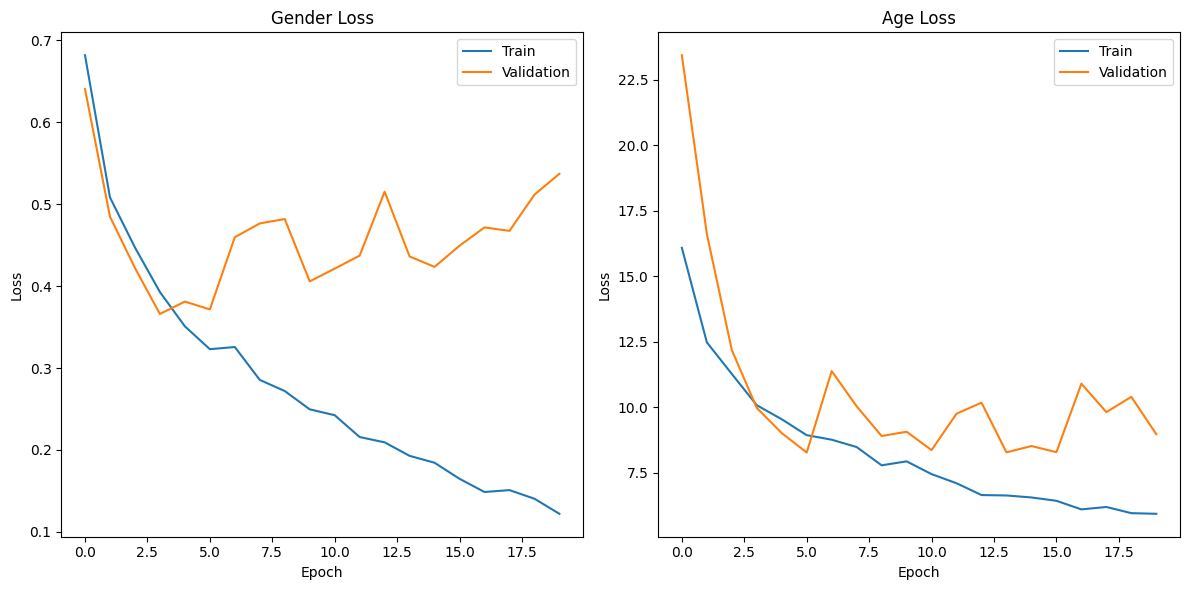

In [25]:
# Plotting gender and age losses together
plt.figure(figsize=(12, 6))

# Gender loss
plt.subplot(1, 2, 1)
plt.plot(model_history.history['gender_output_loss'], label='Train')
plt.plot(model_history.history['val_gender_output_loss'], label='Validation')
plt.title('Gender Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Age loss
plt.subplot(1, 2, 2)
plt.plot(model_history.history['age_output_loss'], label='Train')
plt.plot(model_history.history['val_age_output_loss'], label='Validation')
plt.title('Age Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Original: Gender =  Female  Age =  42.0
1/1 [==============================] - 0s 221ms/step
Prediction: Gender =  Female  Age =  33


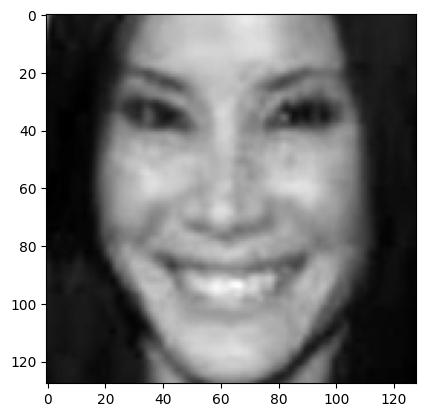

Original: Gender =  Male  Age =  1.0
1/1 [==============================] - 0s 36ms/step
Prediction: Gender =  Male  Age =  0


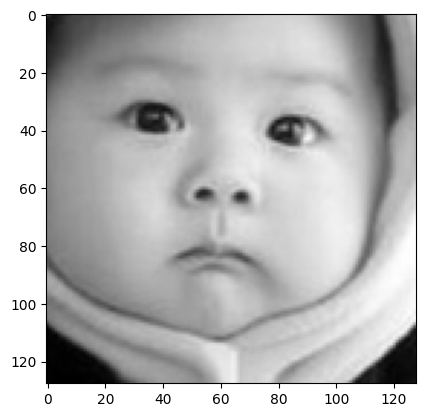

Original: Gender =  Male  Age =  33.0
1/1 [==============================] - 0s 25ms/step
Prediction: Gender =  Male  Age =  33


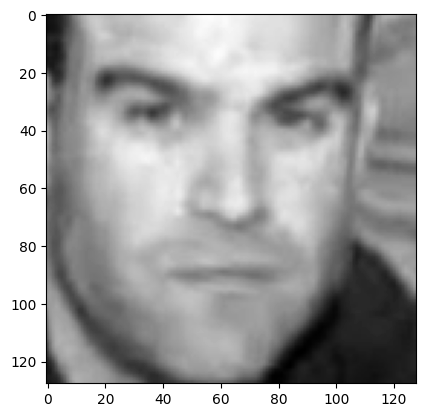

In [26]:
# Define a function for predicting and visualizing multiple test images
def predict_and_visualize(index_list, x_test, y_gender_true, y_age_true, model, gender_dict):
    for index in index_list:
        print("Original: Gender = ", gender_dict[y_gender_true[index]], " Age = ", y_age_true[index])

        # Predict gender and age
        pred = model.predict(x_test[index].reshape(1, 128, 128, 1))
        pred_gender = gender_dict[round(pred[0][0][0])]
        pred_age = round(pred[1][0][0])

        print("Prediction: Gender = ", pred_gender, " Age = ", pred_age)

        # Display the image
        plt.imshow(x_test[index].reshape(128, 128), cmap='gray')
        plt.show()

# Example usage:
index_list = [40,43,30]  # List of indices of test images to predict and visualize
predict_and_visualize(index_list, x_train, y_gender, y_age, model, gender_dict)